In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv
/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv


In [2]:
# Cell for importing packages
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
# cell for importing train and test files
train = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")
test = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")
test.drop(["Unnamed: 0"], axis=1, inplace=True)
train.drop(["Unnamed: 0"], axis=1, inplace=True)
train.head()

,ID,class,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,...,20140610_N,20140525_N,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N
0,1,water,637.5950,658.668,-1882.030,-1924.36,997.904,-1739.990,630.087,NaN,...,NaN,-1043.160,-1942.490,267.138,NaN,NaN,211.328,-2203.020,-1180.19,433.906
1,2,water,634.2400,593.705,-1625.790,-1672.32,914.198,-692.386,707.626,-1670.590,...,NaN,-933.934,-625.385,120.059,364.858,476.972,220.878,-2250.000,-1360.56,524.075
2,4,water,58.0174,-1599.160,NaN,-1052.63,NaN,-1564.630,NaN,729.790,...,-1025.88,368.622,NaN,-1227.800,304.621,NaN,369.214,-2202.120,NaN,-1343.550
3,5,water,72.5180,NaN,380.436,-1256.93,515.805,-1413.180,-802.942,683.254,...,-1813.95,155.624,NaN,-924.073,432.150,282.833,298.320,-2197.360,NaN,-826.727
4,8,water,1136.4400,NaN,NaN,1647.83,1935.800,NaN,2158.980,NaN,...,1535.00,1959.430,-279.317,-384.915,-113.406,1020.720,1660.650,-116.801,-568.05,-1357.140


In [4]:
train.shape
train.columns
train["class"].unique()

array(['water', 'forest', 'impervious', 'farm', 'grass', 'orchard'],
      dtype=object)

In [5]:
test.head()

,ID,20150720_N,20150602_N,20150517_N,20150501_N,20150415_N,20150330_N,20150314_N,20150226_N,20150210_N,...,20140610_N,20140525_N,20140509_N,20140423_N,20140407_N,20140322_N,20140218_N,20140202_N,20140117_N,20140101_N
0,1,7466.42,413.162,5761.00,5625.45,489.403,3923.84,3097.110,6766.42,2829.13,...,801.184,927.115,4704.14,6378.42,340.949,2695.570,527.268,4736.75,601.843,6639.760
1,2,7235.26,6037.350,1027.56,6085.14,1618.050,6668.54,2513.990,1051.69,7268.22,...,5533.470,5103.040,5216.12,4885.27,4366.790,1234.140,3298.110,6942.68,1070.440,842.101
2,3,7425.08,6969.980,1177.94,7408.93,861.061,7644.43,814.458,1504.29,7002.63,...,1981.390,6204.540,7021.69,5704.41,4897.450,1789.990,2206.100,6928.93,1036.560,831.441
3,4,7119.12,1731.620,6311.93,6441.61,465.979,7128.42,1649.120,6935.22,2176.80,...,959.344,5794.150,1045.57,5572.90,586.287,685.906,1287.000,6734.72,824.584,6883.610
4,5,7519.55,8130.260,1482.54,7879.53,1001.210,7937.60,4122.530,1094.51,7951.44,...,7636.070,6996.760,7413.43,4596.13,4511.700,1413.520,3283.940,7937.68,1857.800,1336.920


In [6]:
le = LabelEncoder()
scaler = StandardScaler()

In [7]:
def preprocess(df, labels=True):
    """
    function defined to preprocess the dataset at once (preprocessing pipeline).
    labels=False will be used to preprocess unlabelled data.
    """
    # Impute missing values with column median
    ndvi_cols = [col for col in df.columns if '_N' in col]
    df[ndvi_cols] = df[ndvi_cols].apply(lambda x: x.fillna(x.median()), axis=0)
    
    # Apply rolling mean smoothing -- only three is working.
    df[ndvi_cols] = df[ndvi_cols].rolling(window=3, min_periods=1).mean()

    df['ndvi_mean'] = df[ndvi_cols].mean(axis=1)
    df['ndvi_std'] = df[ndvi_cols].std(axis=1)
    df['ndvi_min'] = df[ndvi_cols].min(axis=1)
    df['ndvi_max'] = df[ndvi_cols].max(axis=1)
    df['ndvi_median'] = df[ndvi_cols].median(axis=1)
    

    feature = df[ndvi_cols + ['ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max', 'ndvi_median']]
    feature_scaled = scaler.fit_transform(feature)

    if labels:
        df["class_encoded"] = le.fit_transform(df["class"])
        target = df['class_encoded']
        return feature_scaled, target
    return feature_scaled

In [8]:
feature, target = preprocess(train)

In [9]:
# Split into train and validation sets (80/20 split, stratified by class)
X_train, X_val, y_train, y_val = train_test_split(feature, target, test_size=0.2, stratify=target, random_state=42)

In [10]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1500, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1500, multi_class='multinomial', random_state=42)

In [11]:
# Predict on the validation set
y_val_pred = model.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.9281


In [12]:
# Detailed performance report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Confusion matrix to see wrong classifications
cf = confusion_matrix(y_val, y_val_pred)


Classification Report:
              precision    recall  f1-score   support

        farm       0.76      0.67      0.71       168
      forest       0.96      0.99      0.97      1232
       grass       0.85      0.56      0.68        39
  impervious       0.86      0.85      0.85       134
     orchard       1.00      0.33      0.50         6
       water       0.86      0.86      0.86        21

    accuracy                           0.93      1600
   macro avg       0.88      0.71      0.76      1600
weighted avg       0.92      0.93      0.92      1600



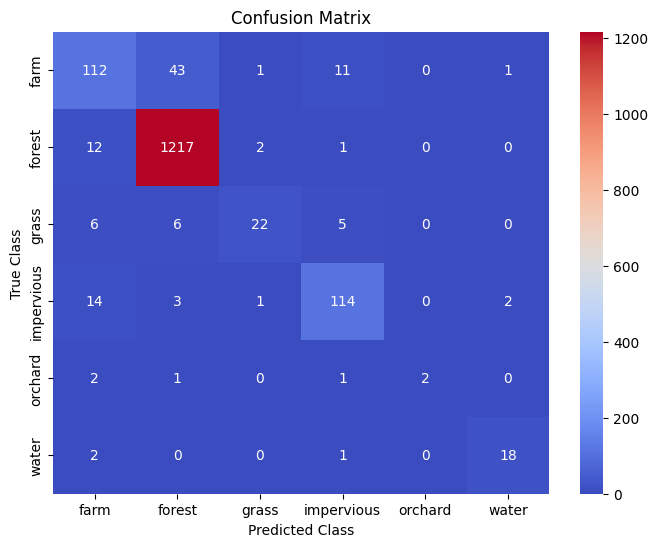

In [13]:
# Plotting results
plt.figure(figsize=(8, 6))
sns.heatmap(cf, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [14]:
test_scaled = preprocess(test, labels=False)

In [15]:
predictions_encoded = model.predict(test_scaled)
predictions = le.inverse_transform(predictions_encoded)

In [16]:
predictions.shape

(2845,)

In [17]:
table = pd.DataFrame({
    'ID' : test['ID'],
    'class' : predictions
})
table.head()

,ID,class
0,1,orchard
1,2,orchard
2,3,orchard
3,4,orchard
4,5,orchard


In [18]:
table.to_csv("submission.csv", index=False)
print("Thanks")

Thanks
